In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
import h5py

In [3]:
sys.path.append("../..")

from WatChMaL.analysis.multi_plot_utils import multi_disp_learn_hist, multi_compute_roc, multi_plot_roc
from WatChMaL.analysis.comparison_utils import multi_get_masked_data, multi_collapse_test_output, collapse_test_output
from WatChMaL.analysis.fitqun_comparison_utils import load_mu_fq_output, load_pion_fq_output, load_gamma_fq_output
from WatChMaL.analysis.performance_analysis_utils import remove_indices
from WatChMaL.analysis.performance_analysis_plot_utils import plot_fitqun_binned_performance, plot_momentum_binned_performance
from WatChMaL.analysis.performance_analysis_plot_utils import plot_true_momentum_binned_performance, plot_to_wall_binned_performance, plot_energy_binned_performance, plot_zenith_binned_performance, plot_azimuth_binned_performance
from WatChMaL.analysis.performance_analysis_plot_utils import plot_to_wall_binned_in_energy, plot_zenith_binned_in_azimuth, plot_azimuth_binned_in_zenith

In [4]:
############# define plotting params #############
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
label_dict = {"$\gamma$":0, "$e$":1, "$\mu$":2, "$\pi 0$":3}
inverse_label_dict = {0:"$\gamma$", 1:"$e$", 2:"$\mu$", 3:"$\pi 0$"}
muon_softmax_index_dict = {"e/gamma":0, "mu":1}

## Define fitqun paths

In [5]:
# Retrieve flags
gamma_file_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_gamma_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
e_file_path     = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_e-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
mu_file_path    = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_mu-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
pion_file_path  = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'

fq_mapping_path = '/home/jtindall/WatChMaL_analysis/fitqun_comparison/fitqun_comparison_prep/prep_data/4_class_3M_fitqun_mapping.pickle'

with open('./prep_data/4_class_3M_fitqun_cuts.pickle', 'rb') as handle:
    cuts = pickle.load(handle)

## Load resnet results

In [6]:
############# define run locations #############
short_locs = [#'/home/jtindall/WatChMaL/outputs/2021-04-06/13-38-38/outputs'
              '/home/jtindall/WatChMaL/outputs/2021-04-13/15-55-14/outputs', # 4 class
              '/home/jtindall/WatChMaL/outputs/2021-04-19/09-44-40/outputs'   # 2 class
              ]

short_titles = ['Short Tank (4-class)', 'Short Tank (2-class)', 'Fitqun']

full_locs = []

full_titles = []

short_linecolor = [c[0] for _ in range(2)]
short_linestyle = ['--' for _ in range(2)]

full_linecolor = [c[1] for _ in full_locs]
full_linestyle = [':' for _ in full_locs]


In [7]:
############# load short tank run data #############
short_raw_output_softmax    = [np.load(loc + "/softmax.npy") for loc in short_locs]
short_raw_actual_labels     = [np.load(loc + "/labels.npy") for loc in short_locs]

In [8]:
locs      = short_locs + full_locs
titles    = short_titles + full_titles
linecolor = short_linecolor + full_linecolor
linestyle = short_linestyle + full_linestyle

## Load h5 Data

In [9]:
# Import test events from h5 file
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"
data_file = h5py.File(data_path, "r")

print(data_file.keys())

energies   = np.array(data_file['energies'])
angles     = np.array(data_file['angles'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


In [10]:
idxs_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_4_class_3M_emgp0_idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)

test_idxs  = idxs['test_idxs']

test_angles    = angles[test_idxs]
test_energies  = energies[test_idxs]
test_positions = positions[test_idxs]
test_labels    = labels[test_idxs]

In [11]:
print(len(test_labels))


4671749


In [12]:
1.2*4

4.8

In [13]:
d_to_wall = np.load('./prep_data/3M_d_to_wall.npz', allow_pickle=True)

test_d_to_wall  = d_to_wall['test_d_to_wall']

In [14]:
true_mom = np.load('./prep_data/3M_momenta.npz', allow_pickle=True)

test_true_mom  = true_mom['test_momenta']

## Verify Indices

In [15]:
e_gamma_4_class_idxs = np.where((test_labels == 0) | (test_labels == 1))[0]

In [16]:
print(np.bincount(short_raw_actual_labels[0]))
print(np.bincount(short_raw_actual_labels[1]))
print(np.bincount(test_labels))
print(np.bincount(test_labels[e_gamma_4_class_idxs]))

[1182377 1177966 1164139 1147267]
[1182377 1177966]
[1182377 1177966 1164139 1147267]
[1182377 1177966]


In [17]:
print(set(short_raw_actual_labels[1] - test_labels[e_gamma_4_class_idxs]))

{0}


## Generate Muon Rejection Based Preselection

### Load 4-class with muons

In [18]:
muon_softmax_index_dict = {"e/gamma":0, "mu":1}

In [19]:
muon_cut_to_apply = cuts['fq_comparison']

muon_raw_short_softmax = short_raw_output_softmax[0]

muon_filtered_short_softmax  = remove_indices(short_raw_output_softmax[0], muon_cut_to_apply)
muon_filtered_labels         = remove_indices(short_raw_actual_labels[0], muon_cut_to_apply)

muon_collapsed_class_scores, muon_collapsed_class_labels = collapse_test_output(muon_filtered_short_softmax, muon_filtered_labels, label_dict, ignore_type='$\gamma$')

muon_collapsed_class_scores = muon_collapsed_class_scores[:,1:]
muon_collapsed_class_labels = muon_collapsed_class_labels - 1 

### Compute Threshold

In [20]:
from WatChMaL.analysis.plot_utils import compute_roc, plot_roc

In [21]:
fpr_fixed_point = 0.005
fprs, tprs, thrs = compute_roc(muon_collapsed_class_scores, muon_collapsed_class_labels, 
                            true_label=muon_softmax_index_dict["e/gamma"], 
                            false_label=muon_softmax_index_dict["mu"],
                            normalize=True)

operating_point_thr = thrs[np.argmin(np.abs(fprs - fpr_fixed_point))]

operating_point_cut = ((muon_raw_short_softmax[:, 0] + muon_raw_short_softmax[:, 1])/(muon_raw_short_softmax[:, 0] + muon_raw_short_softmax[:, 1] + muon_raw_short_softmax[:, 2])) < operating_point_thr

print(tprs[np.argmin(np.abs(fprs - fpr_fixed_point))])
print(fprs[np.argmin(np.abs(fprs - fpr_fixed_point))])

0.9848511202371384
0.004998335338905415


In [22]:
# Verify cut working
comp_idxs = np.where((muon_filtered_labels == 1 ) | (muon_filtered_labels == 2))[0]

scores = ((muon_filtered_short_softmax[:, 0] + muon_filtered_short_softmax[:, 1])/(muon_filtered_short_softmax[:, 0] + muon_filtered_short_softmax[:, 1] + muon_filtered_short_softmax[:, 2]))

pred_pos_idxs = np.where( scores[comp_idxs] >= operating_point_thr)[0]
pred_neg_idxs = np.where( scores[comp_idxs] < operating_point_thr)[0]

true_label, false_label = '$e$','$\mu$'
fp = np.where(muon_filtered_labels[comp_idxs[pred_pos_idxs]] == label_dict[false_label])[0].shape[0]
tp = np.where(muon_filtered_labels[comp_idxs[pred_pos_idxs]] == label_dict[true_label] )[0].shape[0]
fn = np.where(muon_filtered_labels[comp_idxs[pred_neg_idxs]] == label_dict[true_label] )[0].shape[0]
tn = np.where(muon_filtered_labels[comp_idxs[pred_neg_idxs]] == label_dict[false_label])[0].shape[0]

# TODO: division by zero problem
efficiency = performance = tp/(tp + fn + 1e-10)
fpr = performance = fp/(fp + tn + 1e-10)

print(efficiency)
print(fpr)

0.9848511202371382
0.004998335338905414


## Test cut

## Plot ROC

### Without muon preselection

In [23]:
cut_to_apply = cuts['fq_comparison']

updated_cuts = np.zeros_like(test_labels, dtype=bool)
updated_cuts[cut_to_apply] = True

cut_to_apply = np.where(updated_cuts[e_gamma_4_class_idxs])[0]

In [24]:
muon_preselection_short_softmax   = remove_indices(short_raw_output_softmax[0][e_gamma_4_class_idxs], cut_to_apply)
muon_preselection_filtered_labels = remove_indices(short_raw_actual_labels[0][e_gamma_4_class_idxs], cut_to_apply)

In [25]:
fprs, tprs, thrs = compute_roc(muon_preselection_short_softmax, muon_preselection_filtered_labels, 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\gamma$"],
                            normalize=True)

In [26]:
fpr_list = [fprs] 
tpr_list = [tprs]
thr_list = [thrs]

gamma_linestyle = ['--' for _ in range(4)]
gamma_linecolor = [c[i] for i in range(4)]
gamma_titles    = ['Short Tank ResNet (4-Class)', 'Short Tank Fitqun 1', 'Short Tank Fitqun 2', 'Short Tank Fitqun 3']

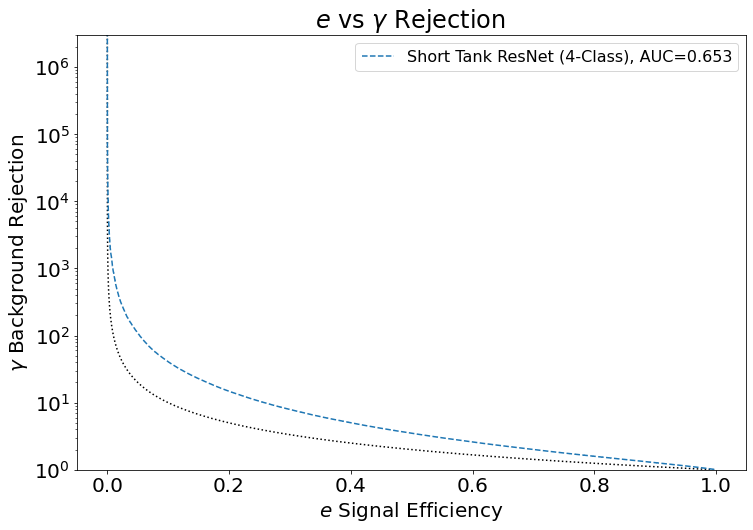

In [27]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

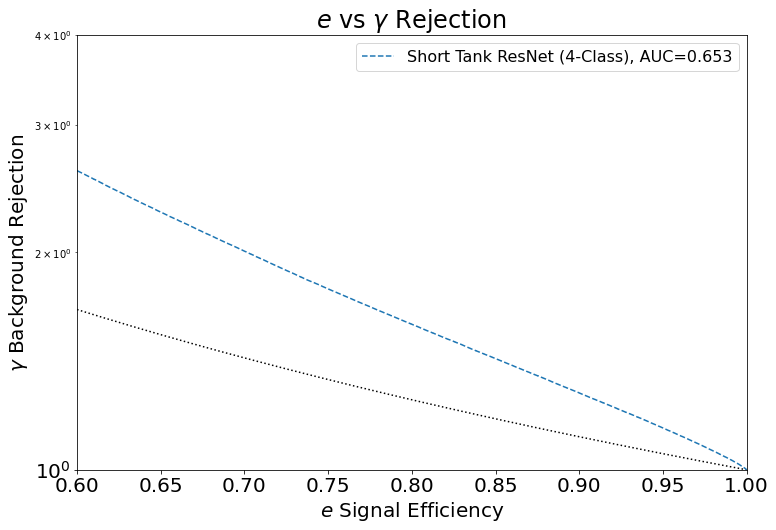

In [28]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], xlims=[[0.6, 1.0]], ylims=[[1,4e0]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

### With muon preselection

In [29]:
cut_to_apply = cuts['fq_comparison']

updated_cuts = np.zeros_like(test_labels, dtype=bool)
updated_cuts[cut_to_apply] = True

pre_muon_cuts = np.where(updated_cuts[e_gamma_4_class_idxs])[0]

updated_cuts[operating_point_cut] = True

cut_to_apply = np.where(updated_cuts[e_gamma_4_class_idxs])[0]

# Compute preslection factors
pre_muon_preselection_labels  = remove_indices(short_raw_actual_labels[0][e_gamma_4_class_idxs], pre_muon_cuts)
post_muon_preselection_labels = remove_indices(short_raw_actual_labels[0][e_gamma_4_class_idxs], cut_to_apply)

print(len(pre_muon_preselection_labels))
print(len(post_muon_preselection_labels))

# Electron
efficiency_correction_factor = len(post_muon_preselection_labels[post_muon_preselection_labels == 1]) / len(pre_muon_preselection_labels[pre_muon_preselection_labels == 1])

print(efficiency_correction_factor)

# Gamma
rejection_correction_factor = len(post_muon_preselection_labels[post_muon_preselection_labels == 0]) / len(pre_muon_preselection_labels[pre_muon_preselection_labels == 0])

print(rejection_correction_factor)

1101872
1089135
0.9848511202371384
0.9919685869715832


In [30]:
a = 2
a *= 4
print(a)

8


In [31]:
muon_preselection_short_softmax   = remove_indices(short_raw_output_softmax[0][e_gamma_4_class_idxs], cut_to_apply)
muon_preselection_filtered_labels = remove_indices(short_raw_actual_labels[0][e_gamma_4_class_idxs], cut_to_apply)

In [32]:
print(len(muon_preselection_filtered_labels))

1089135


In [33]:
fprs, tprs, thrs = compute_roc(muon_preselection_short_softmax, muon_preselection_filtered_labels, 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\gamma$"],
                            normalize=True)

# Update using preselection statistics
tprs = tprs*efficiency_correction_factor
fprs = fprs*rejection_correction_factor

In [34]:
fpr_list = [fprs] 
tpr_list = [tprs]
thr_list = [thrs]

gamma_linestyle = ['--' for _ in range(4)]
gamma_linecolor = [c[i] for i in range(4)]
gamma_titles    = ['Short Tank ResNet (4-Class)', 'Short Tank Fitqun 1', 'Short Tank Fitqun 2', 'Short Tank Fitqun 3']

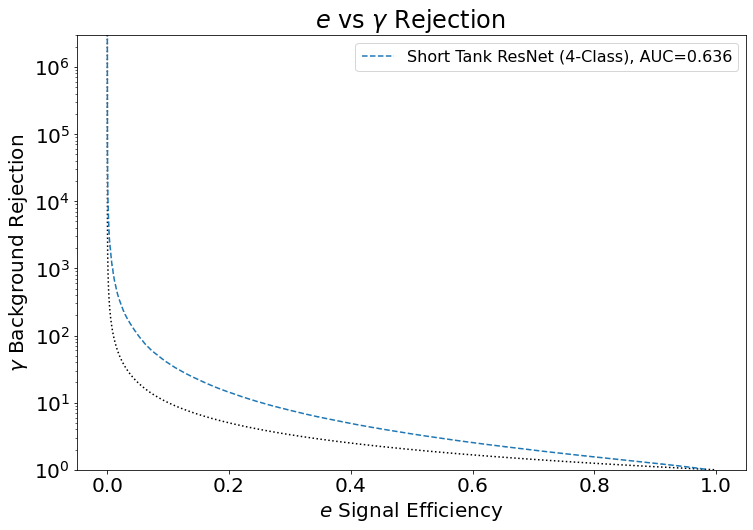

In [35]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

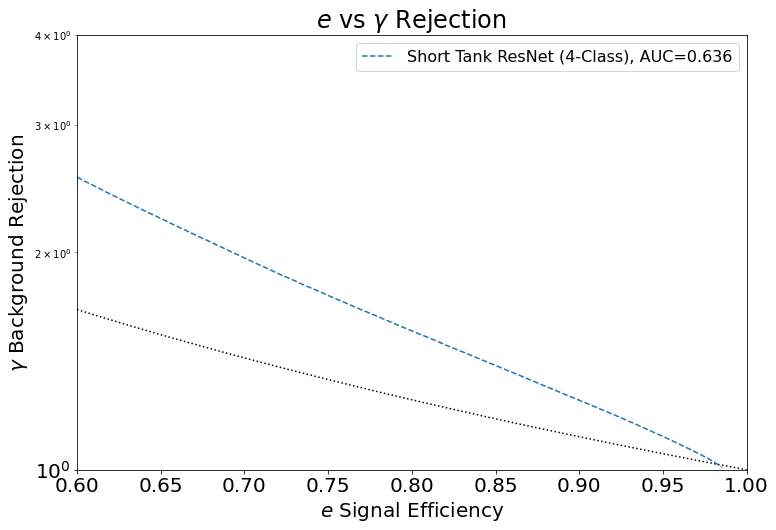

In [36]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], xlims=[[0.6, 1.0]], ylims=[[1,4e0]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

## Plot Performance

In [37]:
fq_scores, fq_labels, fq_mom, fq_masses = load_gamma_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path, discriminator='e_v_mu')


short_output_softmax = [short_raw_output_softmax[0][e_gamma_4_class_idxs], short_raw_output_softmax[1], fq_scores[e_gamma_4_class_idxs]]
short_actual_labels  = [short_raw_actual_labels[0][e_gamma_4_class_idxs] , short_raw_actual_labels[1], fq_labels[e_gamma_4_class_idxs]]

'''
short_output_softmax = [short_raw_output_softmax + [fq_scores[e_gamma_4_class_idxs]]
short_actual_labels  = [short_raw_actual_labels  + [fq_labels[e_gamma_4_class_idxs]]
'''

'\nshort_output_softmax = [short_raw_output_softmax + [fq_scores[e_gamma_4_class_idxs]]\nshort_actual_labels  = [short_raw_actual_labels  + [fq_labels[e_gamma_4_class_idxs]]\n'

In [38]:
filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]

filtered_fq_mom         = remove_indices(fq_mom[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_energies  = remove_indices(test_energies[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_to_wall   = remove_indices(test_d_to_wall[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_true_mom  = remove_indices(test_true_mom[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_energies  = remove_indices(test_energies[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_angles    = remove_indices(test_angles[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_zenith    = filtered_test_angles[:, 0]
filtered_test_azimuth   = filtered_test_angles[:, 1]

scores_list = [(filtered_short_softmax[0][:,1])/(filtered_short_softmax[0][:,0] + filtered_short_softmax[0][:,1]),
               (filtered_short_softmax[1][:,1])/(filtered_short_softmax[1][:,0] + filtered_short_softmax[1][:,1]),
               filtered_short_softmax[2][:,1]]
labels_list = [filtered_labels[0], filtered_labels[1], filtered_labels[2]]
names  = ['ResNet (4-class)', 'ResNet (2-class)', 'FiTQun']
colors = ['r', 'b', 'g']
fpr_rate = 0.2

In [39]:
print(len(filtered_short_softmax[0]))

1089135


In [40]:
plot_true_momentum_binned_performance(
                                 momentum_features      = filtered_test_true_mom,
                                 scores_list            = scores_list, 
                                 labels_list            = labels_list, 
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 yrange                 = [0, 1.1],
                                 xrange                 = [0, 1000],
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels=['$e$','$\gamma$'],
                                 efficiency_correction_factor = efficiency_correction_factor, 
                                 rejection_correction_factor = rejection_correction_factor
                               )

TypeError: plot_single_var_binned_performance() missing 1 required positional argument: 'reconstructed_momentum'

In [ ]:
plot_to_wall_binned_performance(scores_list             = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 to_wall_features       = filtered_test_to_wall,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels=['$e$','$\gamma$']
                               )

In [ ]:
plot_azimuth_binned_performance(scores_list             = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

## Generate $e$-\/$\gamma$ plots

In [ ]:
# TODO: must make plotting function compatible with other particles

## Add fitqun results

In [41]:
fq_scores, fq_labels, fq_mom, fq_masses = load_gamma_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path, discriminator='e_v_mu')


short_output_softmax = [short_raw_output_softmax[0][e_gamma_4_class_idxs], short_raw_output_softmax[1], fq_scores[e_gamma_4_class_idxs]]
short_actual_labels  = [short_raw_actual_labels[0][e_gamma_4_class_idxs] , short_raw_actual_labels[1], fq_labels[e_gamma_4_class_idxs]]

'''
short_output_softmax = [short_raw_output_softmax + [fq_scores[e_gamma_4_class_idxs]]
short_actual_labels  = [short_raw_actual_labels  + [fq_labels[e_gamma_4_class_idxs]]
'''

'\nshort_output_softmax = [short_raw_output_softmax + [fq_scores[e_gamma_4_class_idxs]]\nshort_actual_labels  = [short_raw_actual_labels  + [fq_labels[e_gamma_4_class_idxs]]\n'

### Derive 2 class cuts from 4 class cuts

In [42]:
cut_to_apply = cuts['fq_comparison']

updated_cuts = np.zeros_like(test_labels, dtype=bool)
updated_cuts[cut_to_apply] = True
updated_cuts[operating_point_cut] = True

cut_to_apply = np.where(updated_cuts[e_gamma_4_class_idxs])[0]

### Test by Applying to Single Result

In [43]:
filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]

filtered_fq_mom         = remove_indices(fq_mom[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_energies  = remove_indices(test_energies[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_to_wall   = remove_indices(test_d_to_wall[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_true_mom  = remove_indices(test_true_mom[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_energies  = remove_indices(test_energies[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_angles    = remove_indices(test_angles[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_zenith    = filtered_test_angles[:, 0]
filtered_test_azimuth   = filtered_test_angles[:, 1]

scores_list = [(filtered_short_softmax[0][:,1])/(filtered_short_softmax[0][:,0] + filtered_short_softmax[0][:,1]),
               (filtered_short_softmax[1][:,1])/(filtered_short_softmax[1][:,0] + filtered_short_softmax[1][:,1]),
               filtered_short_softmax[2][:,1]]
labels_list = [filtered_labels[0], filtered_labels[1], filtered_labels[2]]
names  = ['ResNet (4-class)', 'ResNet (2-class)', 'FiTQun']
colors = ['r', 'b', 'g']
fpr_rate = 0.2

### Filter Events by Threshold

### Test by Applying to Single Result

In [44]:
#cut_to_apply = cuts['fq_comparison']
#cut_to_apply = cut_to_apply[cut_to_apply <= np.max(e_gamma_4_class_idxs) ]

filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]

filtered_fq_mom         = remove_indices(fq_mom[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_energies  = remove_indices(test_energies[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_to_wall   = remove_indices(test_d_to_wall[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_true_mom  = remove_indices(test_true_mom[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_energies  = remove_indices(test_energies[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_angles    = remove_indices(test_angles[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_zenith    = filtered_test_angles[:, 0]
filtered_test_azimuth   = filtered_test_angles[:, 1]

scores_list = [(filtered_short_softmax[0][:,1])/(filtered_short_softmax[0][:,0] + filtered_short_softmax[0][:,1]),
               (filtered_short_softmax[1][:,1])/(filtered_short_softmax[1][:,0] + filtered_short_softmax[1][:,1]),
               filtered_short_softmax[2][:,1]]
labels_list = [filtered_labels[0], filtered_labels[1], filtered_labels[2]]
names  = ['ResNet (4-class)', 'ResNet (2-class)', 'FiTQun']
colors = ['r', 'b', 'g']
fpr_rate = 0.2

## Filter results

In [45]:
#cut_to_apply = cuts['fq_comparison']
#cut_to_apply = cut_to_apply[cut_to_apply <= np.max(e_gamma_4_class_idxs) ]

filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]

filtered_fq_mom         = remove_indices(fq_mom[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_energies  = remove_indices(test_energies[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_to_wall   = remove_indices(test_d_to_wall[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_true_mom  = remove_indices(test_true_mom[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_energies  = remove_indices(test_energies[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_angles    = remove_indices(test_angles[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_zenith    = filtered_test_angles[:, 0]
filtered_test_azimuth   = filtered_test_angles[:, 1]

scores_list = [(filtered_short_softmax[0][:,1])/(filtered_short_softmax[0][:,0] + filtered_short_softmax[0][:,1]),
               (filtered_short_softmax[1][:,1])/(filtered_short_softmax[1][:,0] + filtered_short_softmax[1][:,1]),
               filtered_short_softmax[2][:,1]]
labels_list = [filtered_labels[0], filtered_labels[1], filtered_labels[2]]
names  = ['ResNet (4-class)', 'ResNet (2-class)', 'FiTQun']
colors = ['r', 'b', 'g']
fpr_rate = 0.2

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Reconstructed Momentum At\nReconstructed Momentum Fixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Reconstructed Momentum [MeV/c]', ylabel='$e$ Signal Efficiency'>

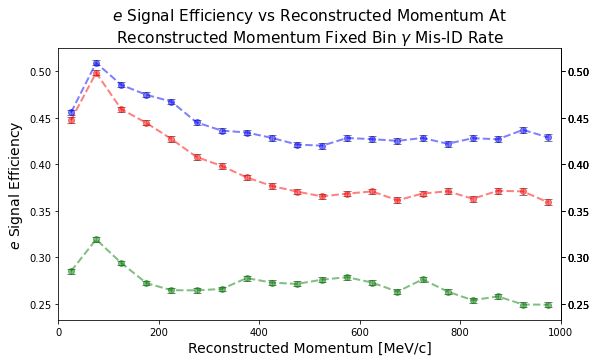

In [86]:
plot_momentum_binned_performance(
                                 reconstructed_momentum = filtered_test_true_mom,
                                 scores_list            = scores_list, 
                                 labels_list            = labels_list, 
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = None,
                                 title_note             = '',
                                 #yrange                 = [0, 1.1],
                                 xrange                 = [0, 1000],
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels=['$e$','$\gamma$'],
                                 show_legend = True
                               )

<AxesSubplot:title={'center':'$\\gamma$ Mis-ID Rate vs Reconstructed Momentum At\nReconstructed Momentum Fixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Reconstructed Momentum [MeV/c]', ylabel='$\\gamma$ Mis-ID Rate'>

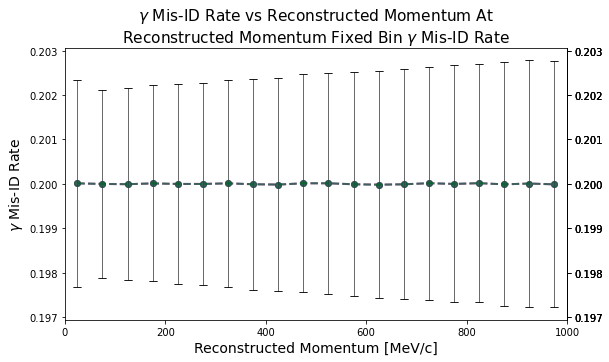

In [85]:
plot_momentum_binned_performance(
                                 reconstructed_momentum = filtered_test_true_mom,
                                 scores_list            = scores_list, 
                                 labels_list            = labels_list, 
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = None,
                                 title_note             = '',
                                 #yrange                 = [0, 0.30],
                                 xrange                 = [0, 1000],
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels=['$e$','$\gamma$'],
                                 metric = 'fpr_rate'
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs To Wall At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='To Wall [cm]', ylabel='$e$ Signal Efficiency'>

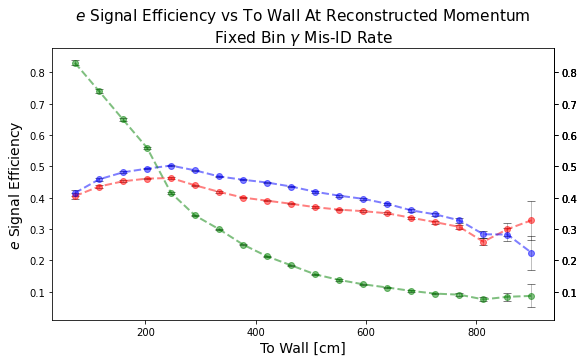

In [48]:
plot_to_wall_binned_performance(scores_list             = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 to_wall_features       = filtered_test_to_wall,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels=['$e$','$\gamma$']
                               )

<AxesSubplot:title={'center':'$\\gamma$ Mis-ID Rate vs To Wall At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='To Wall [cm]', ylabel='$\\gamma$ Mis-ID Rate'>

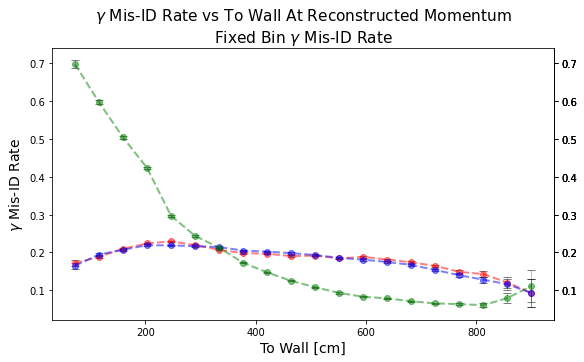

In [49]:
plot_to_wall_binned_performance(scores_list             = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 to_wall_features       = filtered_test_to_wall,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels=['$e$','$\gamma$'],
                                 metric = 'fpr_rate'
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Energy At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Energy [MeV/$c^2$]', ylabel='$e$ Signal Efficiency'>

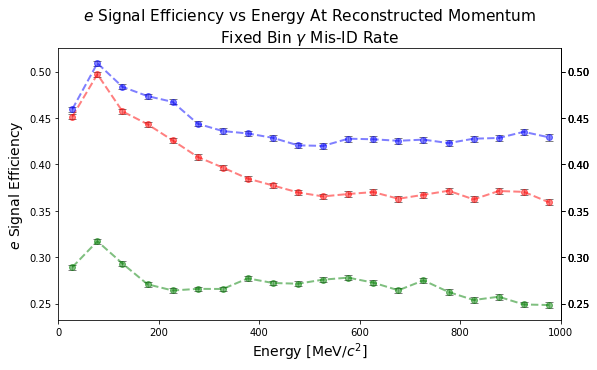

In [50]:
plot_energy_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 energy_features        = filtered_test_energies,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 xrange                 = [0, 1000],
                                 desired_labels=['$e$','$\gamma$']
                               )

0.20001297311322286
0.2
0.19999434804725033
0.20001195528722576
0.2
0.2
0.2000132393340615
0.19999320444429344
0.199985735682191
0.20001467997651204
0.20001506137510355
0.19999218627910612
0.19998398205990708
0.1999917968910217
0.2000169290672084
0.2
0.2000175146685349
0.1999908908726544
0.20000924257128333
0.19999060415296438
Finding metrics...
0.2024449877750605
0.19901706484641582
0.19987003079704968
0.1991474543707967
0.20005502736082603
0.2005395683453231
0.19934434915063348
0.20072234147671064
0.1988956219297924
0.20088105726872174
0.19912340361218092
0.2009144911677341
0.19933461600128188
0.20047752346451425
0.20050944597749865
0.19894304682040445
0.20085244749099132
0.19938134012646047
0.20075282308657375
0.1986344486949775


<AxesSubplot:title={'center':'$\\gamma$ Mis-ID Rate vs Energy At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Energy [MeV/$c^2$]', ylabel='$\\gamma$ Mis-ID Rate'>

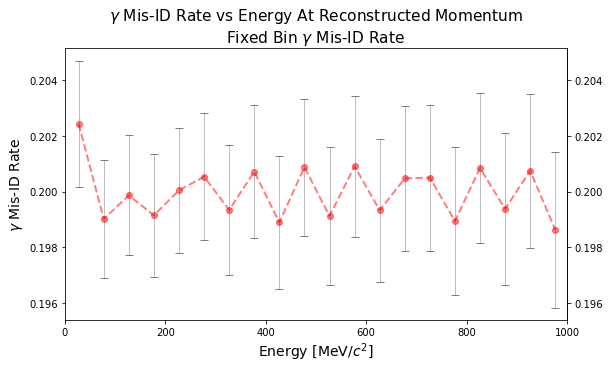

In [72]:
plot_energy_binned_performance(scores_list              = [scores_list[2]], 
                                 labels_list            = [labels_list[2]],
                                 reconstructed_momentum = filtered_test_true_mom,
                                 energy_features        = filtered_test_energies,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 xrange                 = [0, 1000],
                                 desired_labels=['$e$','$\gamma$'],
                               metric = 'fpr_rate'
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Zenith At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Zenith [Radians]', ylabel='$e$ Signal Efficiency'>

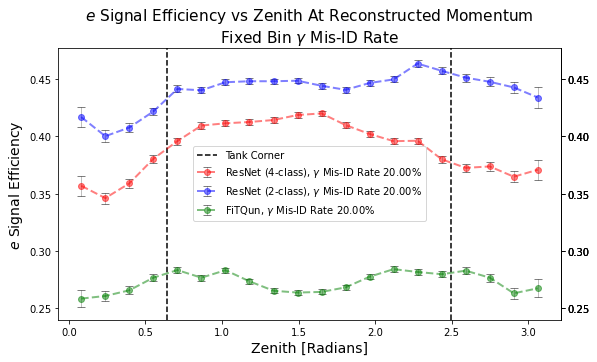

In [52]:
plot_zenith_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 zenith_features        = filtered_test_zenith,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$']
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

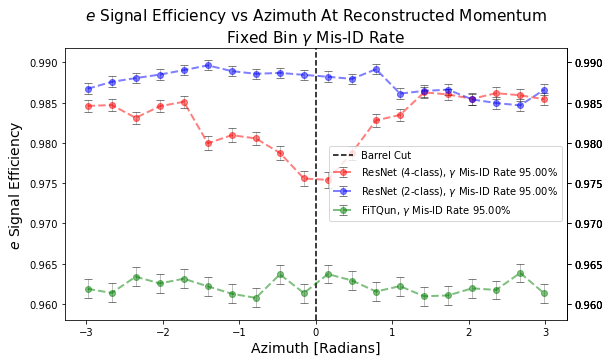

In [53]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.95, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

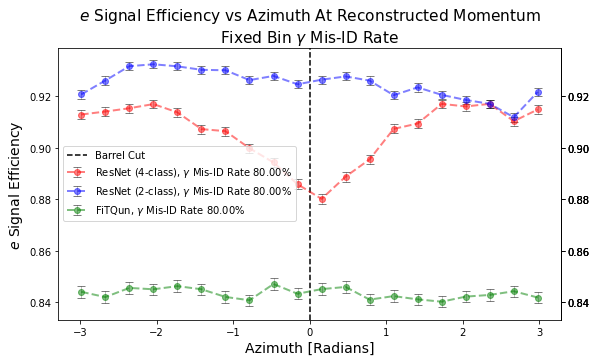

In [54]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.8, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

<AxesSubplot:title={'center':'$\\gamma$ Mis-ID Rate vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$\\gamma$ Mis-ID Rate'>

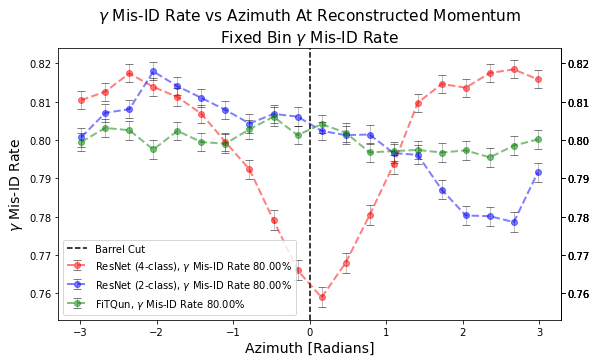

In [55]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.8, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                                 metric                 = 'fpr_rate'
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

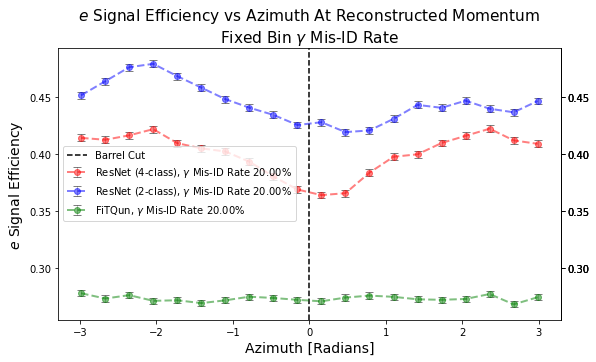

In [55]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.2, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

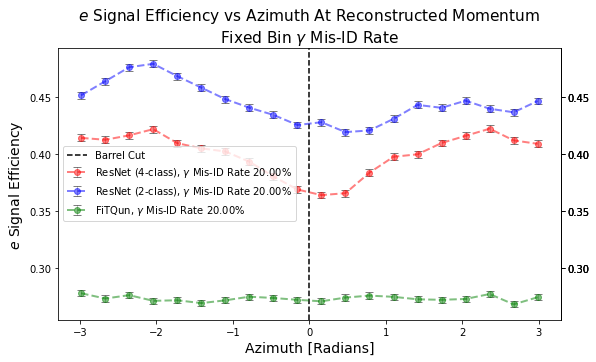

In [56]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.2, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

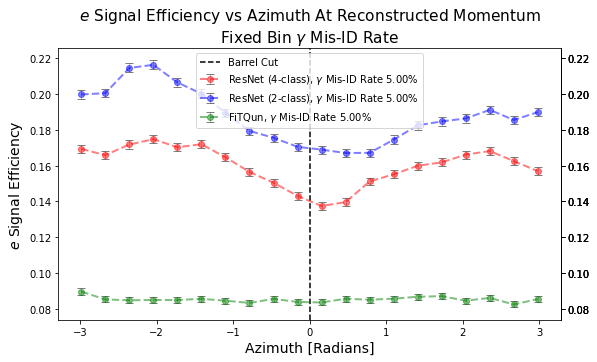

In [57]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.05, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

<AxesSubplot:title={'center':'$\\gamma$ Mis-ID Rate vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$\\gamma$ Mis-ID Rate'>

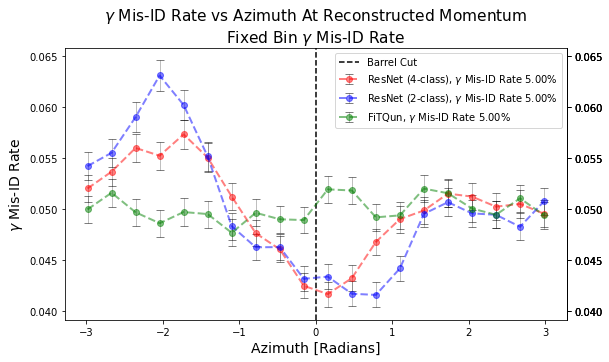

In [58]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.05, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 metric                 = 'fpr_rate',
                                 #yrange                 = [0.57, 0.73]
                               )

## Plot Varying fpr

In [59]:
from WatChMaL.analysis.performance_analysis_plot_utils import plot_varying_efficiency

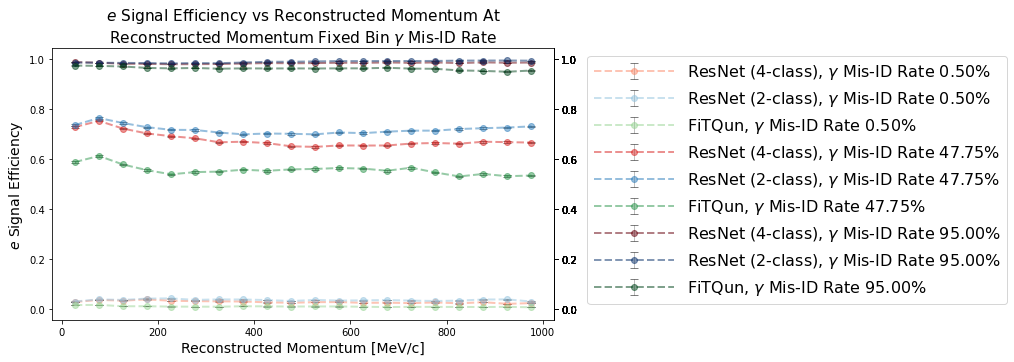

In [60]:
fig, ax = plt.subplots(1,1,figsize=(9,5), facecolor='w')

plot_varying_efficiency(fprs                   = np.linspace(0.005, 0.95, 3),
                        plotting_function      = plot_momentum_binned_performance,
                        scores_list            = scores_list, 
                        labels_list            = labels_list,
                        reconstructed_momentum = filtered_test_true_mom,
                        index_dict             = label_dict, 
                        recons_mom_bin_size    = 50, 
                        plot_bins              = 20,
                        title_note             = '',
                        names                  = names,
                        colors                 = colors,
                        desired_labels         = ['$e$','$\gamma$'],
                        ax                     = ax,
                        #yrange                 = [0.57, 0.73]
                       )

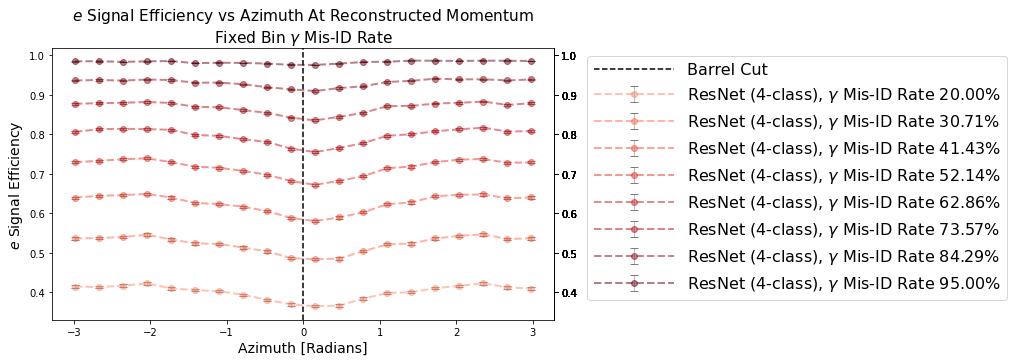

In [61]:
fig, ax = plt.subplots(1,1,figsize=(9,5), facecolor='w')

plot_varying_efficiency(fprs                   = np.linspace(0.2, 0.95, 8),
                        plotting_function      = plot_azimuth_binned_performance,
                        scores_list            = [scores_list[0]], 
                        labels_list            = [labels_list[0]],
                        reconstructed_momentum = filtered_test_true_mom,
                        azimuth_features       = filtered_test_azimuth,
                        index_dict             = label_dict, 
                        recons_mom_bin_size    = 50, 
                        plot_bins              = 20,
                        title_note             = '',
                        names                  = [names[0]],
                        colors                 = [colors[0]],
                        desired_labels         = ['$e$','$\gamma$'],
                        ax                     = ax,
                        #yrange                 = [0.57, 0.73]
                       )

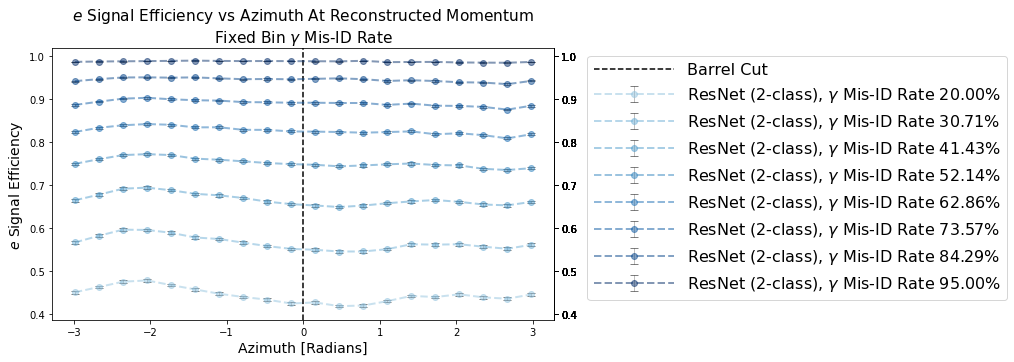

In [62]:
fig, ax = plt.subplots(1,1,figsize=(9,5), facecolor='w')

plot_varying_efficiency(fprs                   = np.linspace(0.2, 0.95, 8),
                        plotting_function      = plot_azimuth_binned_performance,
                        scores_list            = [scores_list[1]], 
                        labels_list            = [labels_list[1]],
                        reconstructed_momentum = filtered_test_true_mom,
                        azimuth_features       = filtered_test_azimuth,
                        index_dict             = label_dict, 
                        recons_mom_bin_size    = 50, 
                        plot_bins              = 20,
                        title_note             = '',
                        names                  = [names[1]],
                        colors                 = [colors[1]],
                        desired_labels         = ['$e$','$\gamma$'],
                        ax                     = ax,
                        #yrange                 = [0.57, 0.73]
                       )

## Multiple Variable Plotting

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs To Wall At Reconstructed Momentum\nBin $\\mu$ Mis-ID Rate of 20.0% in Bins of Energy'}, xlabel='To Wall  [cm]', ylabel='$e$ Signal Efficiency'>

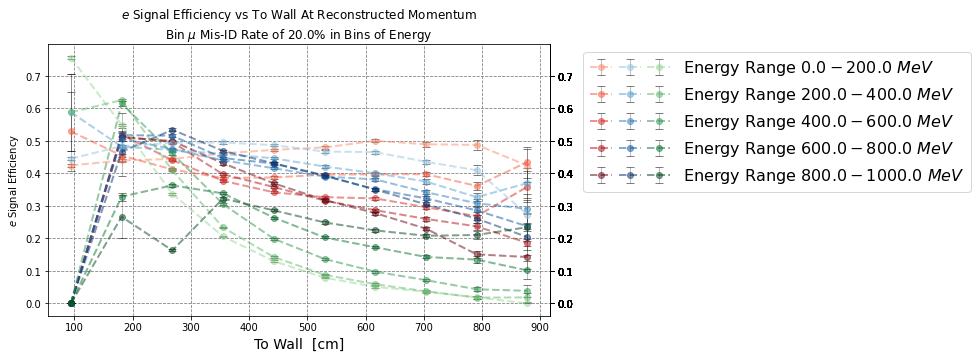

In [63]:
plot_to_wall_binned_in_energy(scores_list            = scores_list, 
                              labels_list            = labels_list,
                              reconstructed_momentum = filtered_fq_mom,
                              binning_features       = filtered_test_energies,
                              binning_bin_size       = 200,
                              to_wall_features       = filtered_test_to_wall,
                              fpr_fixed_point        = fpr_rate, 
                              index_dict             = label_dict, 
                              recons_mom_bin_size    = 50, 
                              plot_bins              = 10,
                              names                  = names,
                              colors                 = colors,
                              desired_labels         = ['$e$','$\gamma$']
                              )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nBin $\\mu$ Mis-ID Rate of 20.0% in Bins of Zenith'}, xlabel='Azimuth  [Radians]', ylabel='$e$ Signal Efficiency'>

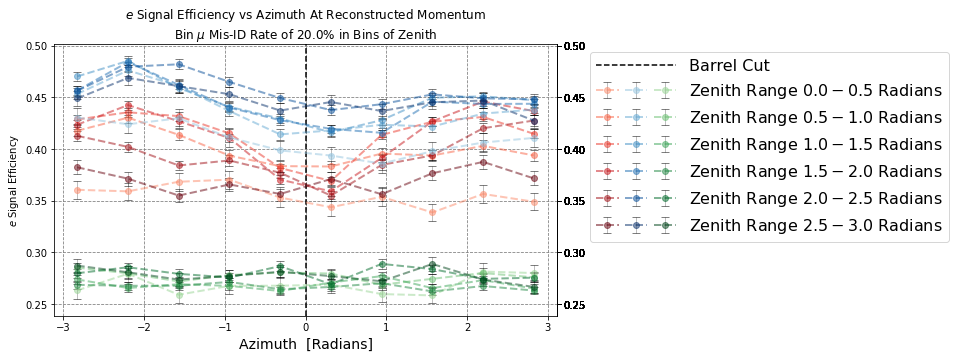

In [64]:
plot_azimuth_binned_in_zenith(scores_list                = scores_list, 
                                  labels_list            = labels_list,
                                  reconstructed_momentum = filtered_fq_mom,
                                  binning_features       = filtered_test_zenith,
                                  binning_bin_size       = 0.5,
                                  azimuth_features       = filtered_test_azimuth,
                                  fpr_fixed_point        = fpr_rate, 
                                  index_dict             = label_dict, 
                                  recons_mom_bin_size    = 50, 
                                  plot_bins              = 10,
                                  names                  = names,
                                  colors                 = colors,
                                  desired_labels         = ['$e$','$\gamma$']
                                  )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Zenith At Reconstructed Momentum\nBin $\\mu$ Mis-ID Rate of 20.0% in Bins of Azimuth'}, xlabel='Zenith  [Radians]', ylabel='$e$ Signal Efficiency'>

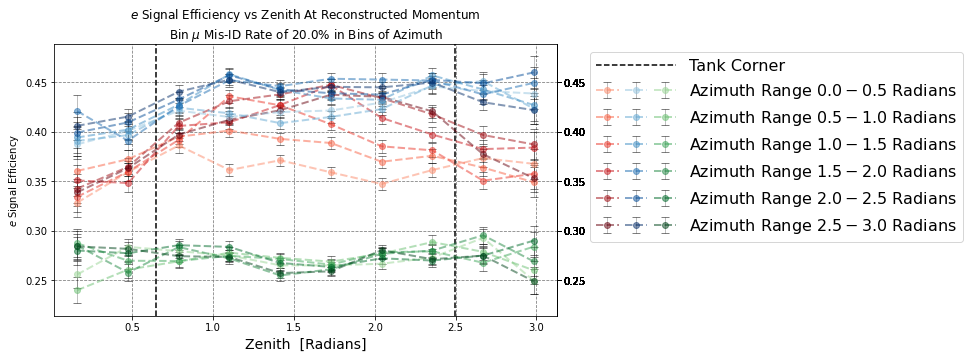

In [65]:
plot_zenith_binned_in_azimuth(scores_list                = scores_list, 
                                  labels_list            = labels_list,
                                  reconstructed_momentum = filtered_fq_mom,
                                  binning_features       = filtered_test_azimuth,
                                  binning_bin_size       = 0.5,
                                  zenith_features        = filtered_test_zenith,
                                  fpr_fixed_point        = fpr_rate, 
                                  index_dict             = label_dict, 
                                  recons_mom_bin_size    = 50, 
                                  plot_bins              = 10,
                                  names                  = names,
                                  colors                 = colors,
                                  desired_labels         = ['$e$','$\gamma$'] 
                                  )

## 2D hist

In [66]:
from WatChMaL.analysis.performance_analysis_plot_utils import  plot_2D_hist

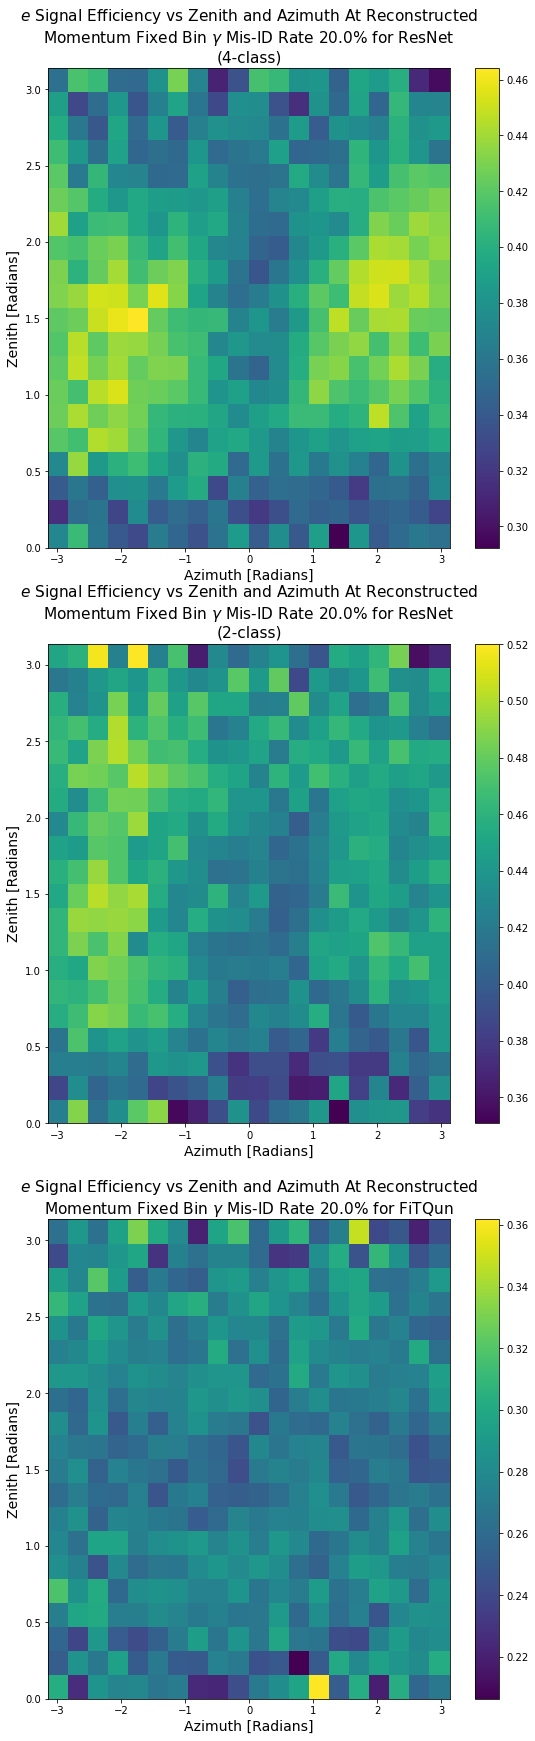

In [67]:
plot_2D_hist(scores_list                = scores_list, 
             labels_list            = labels_list,
             reconstructed_momentum = filtered_fq_mom,
             binning_features       = filtered_test_zenith,
             binning_bins           = 20,
             plot_binning_features  = filtered_test_azimuth,
             fpr_fixed_point        = fpr_rate, 
             index_dict             = label_dict, 
             recons_mom_bin_size    = 50, 
             plot_bins              = 20,
             names                  = names,
             colors                 = colors,
             desired_labels         = ['$e$','$\gamma$']
             )